The coverage is estimated for each sample in the new GENEWIZ samples (project 30-317737003) and compared to that for previous samples.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn import linear_model, neighbors

## Preparation

Running `notebook/2020-04-29-sample-fastq-sizes/runme.sh` on Ada produced the following two tables:

In [2]:
ls ~/projects/bsm/results/2020-04-29-sample-fastq-sizes/*.tsv

/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/fastq-nblocks.tsv
/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/nreads.tsv


In [3]:
fai = pd.read_csv('/big/data/refgenome/GRCh37/dna/hs37d5.fa.fai', header=None, sep='\t')
hg_len_bp = fai.sum()[1]
print(hg_len_bp / 10**9, 'Gb')

3.137454505 Gb


The number of reads for the whole genome was obtained by summing over the number of mapped and unmapped reads for each contig, which in turn was obtained with `samtools idxstats` (see `get_nreads.py`).  The number of reads gave an estimate of coverage using the length of the human genome and the lenght of each read (151).

In [4]:
nreads = pd.read_csv('/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/nreads.tsv', sep='\t', index_col='sample')
nreads['coverage'] = nreads['nreads'] * 151 / hg_len_bp
nreads.tail()

,nreads,path,coverage
sample,,,
PITT_091_NeuN_mn,1040763710,/projects/bsm/alignments/PITT_091/PITT_091_Neu...,50.090071
PITT_091_NeuN_pl,3091314178,/projects/bsm/alignments/PITT_091/PITT_091_Neu...,148.779350
PITT_101_NeuN_pl,3503572864,/projects/bsm/alignments/PITT_101/PITT_101_Neu...,168.620613
PITT_118_NeuN_mn,929306289,/projects/bsm/alignments/PITT_118/PITT_118_Neu...,44.725828
PITT_118_NeuN_pl,4221676035,/projects/bsm/alignments/PITT_118/PITT_118_Neu...,203.181618


In [5]:
nblocks = pd.read_csv('/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/fastq-nblocks.tsv', sep='\t')
nblocks['fq.gz size, GiB'] = nblocks['nblocks, kB'] * 2 ** -20
def fix_samplen(sname):
    newname = re.sub('(MSSM|PITT)', '\\1_', sname)
    newname = re.sub('(pl|mn)1', '\\1_', newname)
    return(newname)
nblocks['sample'] = [fix_samplen(s) for s in nblocks['sample']]
nblocks

,sample,"nblocks, kB",file path,"fq.gz size, GiB"
0,PITT_091_NeuN_pl,9021632,/projects/bsm/reads/PITT091_NeuN_pl/PITT091_Ne...,8.603699
1,PITT_091_NeuN_pl,8035760,/projects/bsm/reads/PITT091_NeuN_pl/PITT091_Ne...,7.663498
2,PITT_091_NeuN_pl,7769508,/projects/bsm/reads/PITT091_NeuN_pl/PITT091_Ne...,7.409580
3,PITT_091_NeuN_pl,8768292,/projects/bsm/reads/PITT091_NeuN_pl/PITT091_Ne...,8.362095
4,PITT_091_NeuN_pl,7779932,/projects/bsm/reads/PITT091_NeuN_pl/PITT091_Ne...,7.419521
...,...,...,...,...
2159,MSSM_109_NeuN_pl_,4391232,/projects/bsm/reads/MSSM109_NeuN_pl1/MSSM109_N...,4.187805
2160,MSSM_109_NeuN_pl_,4934676,/projects/bsm/reads/MSSM109_NeuN_pl1/MSSM109_N...,4.706074
2161,MSSM_109_NeuN_pl_,4306656,/projects/bsm/reads/MSSM109_NeuN_pl1/MSSM109_N...,4.107147
2162,MSSM_109_NeuN_pl_,4960984,/projects/bsm/reads/MSSM109_NeuN_pl1/MSSM109_N...,4.731163


Now get samples present in both data frame and filter data frames for those samples.  Then sort according to `nreads`.

In [6]:
fsize = nblocks.groupby('sample').sum()
samples = set(fsize.index).intersection(nreads.index)
nreads = nreads.loc[samples, :].sort_values('nreads', ascending=False)
fsize = fsize.loc[nreads.index, :]
df = pd.concat([nreads, fsize], axis=1)[['nreads', 'coverage', 'fq.gz size, GiB']]
print(df.head(), '\n' * 2, df.tail())

                      nreads    coverage  fq.gz size, GiB
sample                                                   
MSSM_373_NeuN_pl  5126657796  246.736750       418.182316
PITT_118_NeuN_pl  4221676035  203.181618       348.390968
MSSM_215_NeuN_pl  3992458107  192.149774       323.420944
MSSM_183_NeuN_pl  3733596080  179.691214       307.038284
MSSM_369_NeuN_pl  3348853213  161.174237       272.427040 

                      nreads   coverage  fq.gz size, GiB
sample                                                 
MSSM_118_muscle   802078851  38.602602        67.163513
MSSM_183_muscle   794585616  38.241966        66.080299
MSSM_179_NeuN_mn  767418276  36.934451        63.949398
PITT_010_NeuN_mn  735747926  35.410214        61.114750
MSSM_179_muscle   656607857  31.601346        66.167599


## Analysis
### Exploration
Plot **coverage** agains Gzipped fastq size (**fq.gz size, GiB**) for each sample.  Use both linear and log scale.

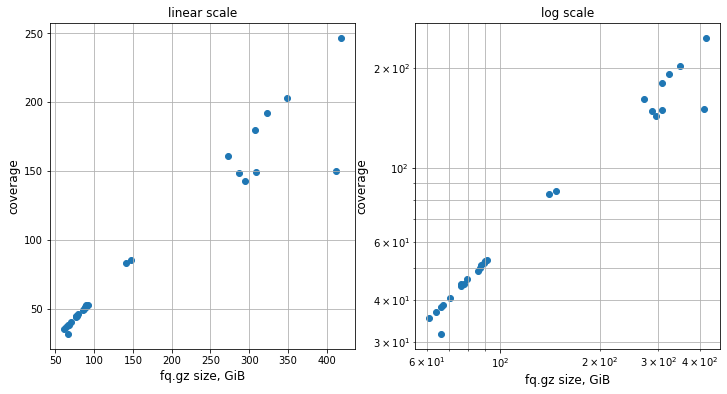

In [11]:
def myscatter(ax, scale='linear'):
    ax.scatter(df['fq.gz size, GiB'], df['coverage'])
    ax.set_xlabel('fq.gz size, GiB', fontsize='large')
    ax.set_ylabel('coverage', fontsize='large')
    ax.grid(b=True, which='both')
    #ax.grid(b=True, which='minor', linestyle=':')
    plt.xscale(scale)
    plt.yscale(scale)
    ax.set_title(scale + ' scale')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
myscatter(ax[0], 'linear')
myscatter(ax[1], 'log')

The graph reveals a linear relationship for most samples, while some samples seem to be outliers.

### Fitting linear model

Fit linear model and evaluate squared error for each point of the training data

In [8]:
X = np.log10(np.array(df['fq.gz size, GiB']))[:, np.newaxis]
y = np.log10(np.array(df['coverage']))[:, np.newaxis]
lm = linear_model.LinearRegression().fit(X, y)
y_hat = lm.predict(X)
X_fig = np.linspace(1.8, 2.7, 2)[:, np.newaxis]
y_fig = lm.predict(X_fig)
sq_error = (y_hat[:, 0] - y[:, 0]) ** 2
sq_error_sorted = sq_error.copy()
sq_error_sorted.sort()
print(sq_error_sorted)

[1.26093374e-07 7.90619742e-07 9.94602314e-07 1.69313303e-06
 1.85058241e-06 5.02388283e-06 5.36767657e-06 8.16902998e-06
 3.16486223e-05 3.31797621e-05 4.13241789e-05 6.66770227e-05
 7.65513964e-05 7.72874834e-05 1.21850898e-04 1.40918810e-04
 3.97182839e-04 9.10314118e-04 1.58731062e-03 1.72051032e-03
 1.75796529e-03 1.88622189e-03 1.91679166e-03 2.47085521e-03
 2.79254691e-03 6.89254472e-03 2.46388185e-02]


Plot results:


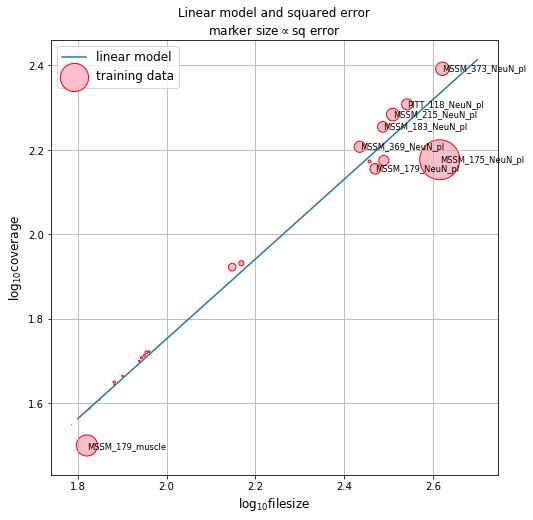

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(X_fig[:, 0], y_fig[:, 0], label='linear model')
ax.scatter(X[:, 0], y[:, 0], s=5*sq_error/np.median(sq_error), c='pink', edgecolor='red', marker='o', label='training data')
ax.legend(fontsize='large')
ax.set_title('Linear model and squared error\nmarker size$\propto$sq error')
ax.set_xlabel('$\log_{10} \mathrm{filesize}$', fontsize='large')
ax.set_ylabel('$\log_{10} \mathrm{coverage}$', fontsize='large')
ax.grid(b=True, which='both')
for sqe, s, xx, yy in zip(sq_error, df.index, X[:, 0], y[:, 0]):
    if sqe > 1.7e-3:
        ax.text(xx, yy, s, horizontalalignment='left', verticalalignment='center', fontsize='small')

In [10]:
%connect_info

{
  "shell_port": 45079,
  "iopub_port": 60053,
  "stdin_port": 33433,
  "control_port": 48349,
  "hb_port": 53931,
  "ip": "127.0.0.1",
  "key": "dc34b9e4-9782ac4a7587f86d1516d7f5",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-069c7fbd-ed03-480e-a214-fd692f843ce9.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
